# Check cell locations

**Brief**:

* 1,225 near-contact (w/n 50 microns) pyramidal neurons
* Layers 2/3 to 6
* 0.07% of `S1FL` region

**Notes**:

* A single 4 secs simulation is too large to be read in RAM with `bluepy` on a compute node in interactive mode (with --mem=0). The associated `lfp.h5` is 1.2TB.
* cells from the 30K cells microcircuit are the `hex0`

# Setup

Setup Jupyter notebook's kernel based on python env setup with `requirements_silico.txt` (see comments in file for setup)

In [1]:
# SETUP PACKAGES
%load_ext autoreload
%autoreload 2
import os
import pprint as pp
import pandas as pd
import yaml
import numpy as np
from matplotlib import pyplot as plt
import spikeinterface as si
import spikeinterface.widgets as sw
import spikeinterface.postprocessing as spost
from probeinterface.plotting import plot_probe
from spikeinterface.comparison import GroundTruthStudy
import shutil

pd.set_option('display.max_colwidth', None)

# SET PATHS
PROJ_PATH = "/gpfs/bbp.cscs.ch/project/proj68/home/laquitai/spike-sorting"

os.chdir(PROJ_PATH)
from src.nodes.io.silico.loading import load_campaign_params
from src.nodes.truth.silico import ground_truth
from src.nodes.io.silico import loading_raw_recording
from src.nodes.prepro import preprocess
from src.nodes.utils import get_config
from src.nodes.postpro import waveform
from src.nodes.dataeng.silico.filtering import filter_microcircuit_cells, get_cell_id_spiking_above_thresh, get_most_active_cell

# SET PARAMETERS
EXPERIMENT = "supp/silico_reyes"    # specifies the experiment 
SIMULATION_DATE = "2023_01_13" # specifies the run (date)

# set neuron filtering
MIN_SPIKE = 0
MS_BEFORE = 3 # ms
MS_AFTER = 3 # ms
CHANNEL_IDS = np.arange(64,80).tolist()   # plot traces from channels nearest to filtered neuron group


# SETUP CONFIG
data_conf, param_conf = get_config(EXPERIMENT, SIMULATION_DATE).values()


# SET PATHS
STUDY_FOLDER = data_conf["postprocessing"]["waveform"]["study"]
SPIKE_FILE_PATH = data_conf["sorting"]["simulation"]["ground_truth"]["input"]
LFP_TRACE_FILE_PATH = data_conf["dataeng"]["campaign"]["output"]["trace_file_path"]

2023-02-14 08:45:35,645 - root - utils.py - get_config - INFO - Reading experiment config.
2023-02-14 08:45:35,729 - root - utils.py - get_config - INFO - Reading experiment config. - done


## Describe cells

In [3]:
# stats: takes 1:30 min for a 40 secs simulation - 1225 cells
# load campaign parameters
simulation = load_campaign_params(data_conf)

# get microcircuit's 30K cells
microcircuit_cells = filter_microcircuit_cells(simulation)

# get Spikeinterface's Sorting object for near-probe cells
output = ground_truth.run(simulation, data_conf, param_conf)
SortingObject = output["ground_truth_sorting_object"]

# get cell properties
# get active cells (spike count above MIN_SPIKE)
active_cell_gids = get_cell_id_spiking_above_thresh(SortingObject, min_spike=MIN_SPIKE)

# get cell morph_class
cell_morph_class = simulation["circuit"].cells.get(
    SortingObject.unit_ids, properties=["morph_class"]
)

# get pyramidal cells
pyramidal_gids = cell_morph_class[cell_morph_class["morph_class"] == "PYR"].index.values

# get active pyramidal cells
active_pyramidal_gids = list(set(pyramidal_gids) & set(active_cell_gids))

# get the most active pyramidal cell and its spike count
most_active_pyr_gid = get_most_active_cell(SortingObject, cell_id=pyramidal_gids)
print("CELL ID:", most_active_pyr_gid)

CELL ID: 3754013


In [5]:
# stats: 7 mins for a 40 secs simulation - 1225 cells
# set parameters
N_SAMPLE = 160000
MIN_MAX_AMPLITUDE = [-150, 150]

# preprocess lfp
prepro_traces = preprocess.run(data_conf, param_conf)
probe = prepro_traces.get_probe()

# get the coordinates of our target cell
most_active_pyr_gid_true_loc = simulation["circuit"].cells.get(
    most_active_pyr_gid, properties=["x", "y", "z"]
)
print("most active cell's true coordimates:\n", most_active_pyr_gid_true_loc)

# create a SpikeInterface WaveformExtractor
WaveformExtractor = waveform.run_from_files(
    experiment=EXPERIMENT,
    simulation_date=SIMULATION_DATE,
    lfp_trace_file=LFP_TRACE_FILE_PATH,
    spike_file=SPIKE_FILE_PATH,
    study_folder=STUDY_FOLDER,
    ms_before=MS_BEFORE,
    ms_after=MS_AFTER,
)

# locate units
unit_locations = spost.compute_unit_locations(
    WaveformExtractor, method="center_of_mass", outputs="by_unit"
)
most_active_unit_estimated_loc = unit_locations[most_active_pyr_gid]
print("estimated coordinates:", most_active_unit_estimated_loc)

# create a Spikeinterface SortingExtractor for near-probe cells
output = ground_truth.run(simulation, data_conf, param_conf)
SortingObject = output["ground_truth_sorting_object"]

write_binary_recording with n_jobs = 1 and chunk_size = None
most active cell's true coordimates:
 x    3820.476353
y     -1143.5028
z   -2538.452514
Name: 3754013, dtype: object
2023-02-10 13:42:21,695 - root - utils.py - get_config - INFO - Reading experiment config.
2023-02-10 13:42:21,713 - root - utils.py - get_config - INFO - Reading experiment config. - done
write_binary_recording with n_jobs = 1 and chunk_size = None
write_binary_recording with n_jobs = 1 and chunk_size = None
estimated coordimates: [ 3883.77568921 -1184.72606754]


cell's estimated (cross) and true (dot) locations


/tmp/ipykernel_234580/797911669.py:28: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout();


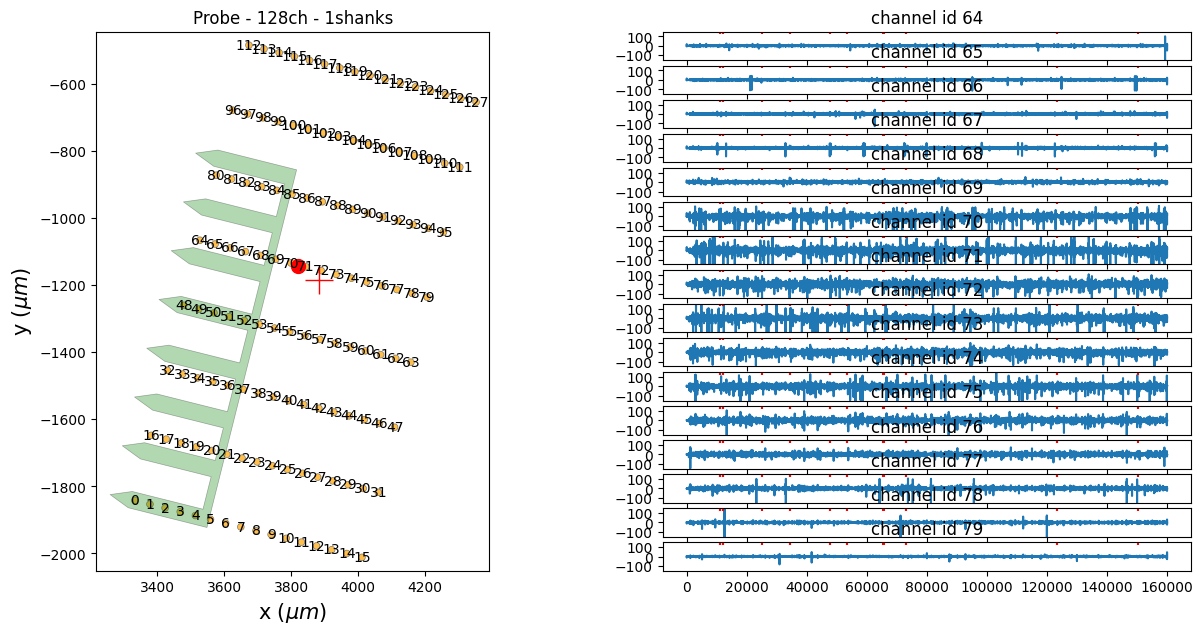

In [6]:
# setup plot
fig = plt.figure(figsize=(15, 7))
spec = fig.add_gridspec(len(CHANNEL_IDS), 2)

# plot the probe
ax = fig.add_subplot(spec[:, 0])
plot_probe(probe.to_2d(axes="xy"), ax=ax, with_channel_index=True)

# plot the cell's estimated location via "center of mass" method
ax.plot(
    most_active_unit_estimated_loc[0],
    most_active_unit_estimated_loc[1],
    "r+",
    markersize=20,
)

# plot the cell's true location
ax.plot(
    most_active_pyr_gid_true_loc.x, most_active_pyr_gid_true_loc.y, "r.", markersize=20
)
print("cell's estimated (cross) and true (dot) locations")

# get most active cells' spikes
most_active_pyr_spikes = SortingObject.get_unit_spike_train(unit_id=most_active_pyr_gid)
most_active_pyr_spikes = most_active_pyr_spikes[most_active_pyr_spikes < N_SAMPLE]

# plot spikes against lfps
for ix in range(len(CHANNEL_IDS)):
    ax = fig.add_subplot(spec[ix, 1])
    trace = prepro_traces.get_traces()[:N_SAMPLE, CHANNEL_IDS[ix]]
    ax.plot(trace)
    ax.eventplot(
        most_active_pyr_spikes,
        linelengths=20,
        lineoffsets=MIN_MAX_AMPLITUDE[1] * 0.9,
        colors="r",
    )
    ax.set_title(f"channel id {CHANNEL_IDS[ix]}")
    ax.set_ylim(MIN_MAX_AMPLITUDE)
plt.tight_layout()

# References

(1) https://probeinterface.readthedocs.io/en/stable/examples/ex_05_device_channel_indices.html 

(2) https://spikeinterface.readthedocs.io/en/latest/modules/core/plot_4_waveform_extractor.html 